In [13]:
import os 
import numpy as np
from tqdm import tqdm 
os.chdir("/home/bumjin/fairseq")

In [14]:
import torch
from fairseq.models.bart import BARTModel

bart = BARTModel.from_pretrained(
    'checkpoints/',
    checkpoint_file='checkpoint_bestBART_BASE.pt',
    data_name_or_path='data/cnn_dm-base-bin'
)

bart.cuda(1)
bart.eval()
bart.half()
count = 1
bsz = 128
TOTAL = 1e17
with open('data/cnn_dm-base/test.source') as source, open('data/cnn_dm-base/V0_test.hypo', 'w') as fout:
    sline = source.readline().strip()
    slines = [sline]
    for sline in tqdm(source):
        if count % bsz == 0:
            with torch.no_grad():
                hypotheses_batch = bart.sample(slines, beam=4, lenpen=2.0, max_len_b=140, min_len=55, no_repeat_ngram_size=3)
            for hypothesis in hypotheses_batch:
                fout.write(hypothesis + '\n')
                fout.flush()
            slines = []
        


        slines.append(sline.strip())
        count += 1
    if slines != []:
        hypotheses_batch = bart.sample(slines, beam=4, lenpen=2.0, max_len_b=140, min_len=55, no_repeat_ngram_size=3)
        for hypothesis in hypotheses_batch:
            fout.write(hypothesis + '\n')
            fout.flush()



11489it [1:20:12,  2.39it/s]


In [15]:
source = open('data/cnn_dm-base/test.source', "r", encoding="utf8")
target = open('data/cnn_dm-base/test.target', "r", encoding="utf8")
hypoth = open('data/cnn_dm-base/V0_test.hypo',   "r", encoding="utf8").readlines()

In [16]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = []
for i in range(len(hypoth)):
    scores.append(scorer.score(target.readline(), hypoth[i]))


In [17]:
R1 = [s['rouge1'][2] for s in scores]
R2 = [s['rouge2'][2] for s in scores]
RL = [s['rougeL'][2] for s in scores]

Rgoue1-F1 : 0.26
Rouge2-F1 : 0.057
RougeL-F1 : 0.17


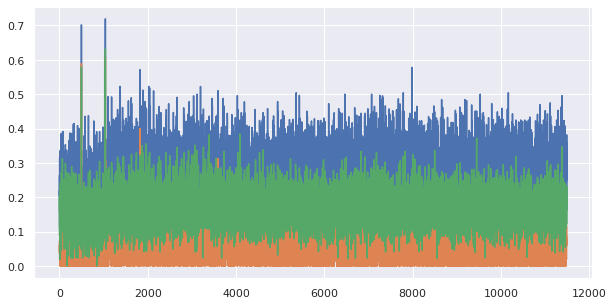

In [18]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme(style="darkgrid")

plt.figure(figsize=(10,5))
sns.lineplot([i for i in range(len(R1))], R1)
sns.lineplot([i for i in range(len(R1))], R2)
sns.lineplot([i for i in range(len(R1))], RL)
print("Rgoue1-F1 :", np.mean(R1).round(3)) 
print("Rouge2-F1 :", np.mean(R2).round(3))
print("RougeL-F1 :", np.mean(RL).round(3))